**Original author:  Camilo J. Torres             
created:  march of 2024
          personal email: <camilojtorresc@gmail.com>
          email:  <camilo.torres@cern.ch>**

v7_g updates:
- Add columns with the information of the total linear momentum in x, y and z to the Cluster df.
- Every cluster counter re-starts in every shower. Sh:1 -> Clust:1,2,3,...  Sh:2 -> Clust:1,2,3,... 
- Correct the variables X, Y, T from the measurement plane to the shower front plane (Xcorr, Ycorr, Tcorr)
- Change the variables (X, Y, T) in the cluster data frame for variables corrected (Xcorr, Ycorr, Tcorr)

![plots/particle_meas_to_corr.png](plots/particle_meas_to_corr.png) 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

#Print and Output parameters:
'''
iprint= 1            # 1 print headers, 0 noprint
Int_t mxshop = 50;   # Mx. N.Showers to print
Int_t mxclup = 50;   # Mx. N.Clusters/Shw to print
Int_t mxparp = 500;  # Mx. N.Particles/Energy to print
'''

In [2]:
# -------------------- INPUTS --------------------------------
# Detector size
det_dx = 1.0 # detector size in x axis (m)
det_dy = 1.0 # detector size in y axis (m)
#
# Some data
vc    = 300 # mm/ns
r2deg = 180/np.pi
#
# Define local particles codes for labeling clusters
# Particle Corsika PID       P. Code
# Gamma        1              1
# Electrons    2,3            1000
# Muons        5,6            100000
# Pions        8,9            50000000
# Protons      14             10000000
# Neutrons     13             100000000
nop   = -999.
gam   = 1.
ele   = 1000.
mu    = 100000.
prn   = 10000000.
ntn   = 100000000. 
pi    = 500000000.
#
codmap   = {1.:gam,2.:ele,3.:ele,5.:mu,6.:mu,8.:pi, 9.:pi, 13.:ntn, 14.:prn}
#
# Define particle masses
mgam  = 0.
mele  = 0.000511
mmu   = 0.1057
mprn  = 0.9383
mntn  = 0.9396 
mpi   = 0.1396
#
masmap   = {1.:mgam,2.:mele,3.:mele,5.:mmu,6.:mmu,8.:mpi, 9.:mpi, 13.:mntn, 14.:mprn}

In [3]:
#Path of the file with the data of particles
#path = r'/afs/cern.ch/work/c/ctorresc/public/CosmicRays/ClusterAnalysis/Data'
#os.chdir(path)
os.chdir('/Users/JAG/progs/buap/oliver')
#
# Run summary
Energies = {'E1': 9, 'E2': 11, 'E3': 14, 'E4': 18, 'E5': 55, 'E6':70}
Run = {'SCod': 'Corsika-77500','Mass':[1],'Lab': ['BUAP'], 'NShows':[1000], 'EInf': Energies['E1'] , 'ESup': Energies['E2'], 'AAInf':[0], 'AASup':[25]} 
Run = pd.DataFrame(Run)
Run = Run.rename(columns={'SCod': 'Sim_Code', \
                        'Mass'  : 'PCR_Mass', \
                        'EInf'  : 'PCR_EMin', \
                        'ESup'  : 'PCR_EMax', \
                        'AAInf' : 'PCR_ThMin', \
                        'AASup' : 'PCR_ThMax'})
Run['Det_S']= det_dx* det_dy
#
# Quizas se podria incluir aqui un intervalo de generacion de la altura de
# la primer interaccion para casos futuros
# ... y otros datos de la generacion: altitud, cmagnetico, particle-cuts
# ... poner primero el Lab y despues la masa...
# Quizas se podrian incluir en RUN otros parametros usados en la simulacion:
# - altura, cortes en energia, campo magnetico, etc. para poder reproducir a ampliar la simulacion en caso necesrio
#
#Input File with summary of Showers
Showers = pd.read_csv(r'DAT000006_1k_showers.txt',delimiter='\t')
#
Showers = Showers.rename(columns={'NShow': 'iShow',\
                                'Energy' : 'PCR_Ene',\
                                'ZFInt'  : 'PCR_FIntH',\
                                'ZhAng'  : 'PCR_Theta',\
                                'AzAng'  : 'PCR_Phi',\
                                'NParticles'  : 'NPart',\
                                })
#
#Input File with information of all particles at observation level
Particles = pd.read_csv('DAT000006_1k_particles.txt',delimiter='\t')
#
Particles = Particles.rename(columns={'ZhA': 'Theta',\
                                    'AzA': 'Phi',\
                                    'PSq': 'P',\
                                    'DetX': 'Det_Xc',\
                                    'DetY': 'Det_Yc',\
                                     })
Particles['P'] = np.sqrt(Particles['Px']**2 + Particles['Py']**2 + Particles['Pz']**2)
#
# Quizas se puede quitar P y dejar la energia que definimos despues...
# Como esta definido Phi para las particulas? Casi todas tienen valores
# cercanos a 180 o -180 !!!
#

In [4]:
Run.head()

,Sim_Code,PCR_Mass,Lab,NShows,PCR_EMin,PCR_EMax,PCR_ThMin,PCR_ThMax,Det_S
0,Corsika-77500,1,BUAP,1000,9,11,0,25,1.0


In [5]:
#Statistics of the data frame with summary of showers 
Showers.describe()
#Showers
#Showers[Showers['NShow']==1]

,iShow,PCR_Ene,PCR_FIntH,PCR_Theta,PCR_Phi,NPart
count,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,1000.0,21.396341,16.782101,1.872360,76.248000
std,288.819436,0.0,8.507688,6.120089,103.589486,95.304866
min,1.000000,1000.0,5.456020,0.982348,-179.486000,6.000000
25%,250.750000,1000.0,15.546450,12.346550,-90.616200,29.000000
50%,500.500000,1000.0,19.986050,17.672750,1.691315,43.000000
75%,750.250000,1000.0,25.346650,22.010350,96.001550,79.000000
max,1000.000000,1000.0,69.751400,25.797300,179.768000,896.000000


In [6]:
pmass = Particles['PId'].map(masmap)
Particles['R'] = np.sqrt(Particles['X']**2 + Particles['Y']**2)
nshow = Particles.pop('NShow')
Particles.insert(1, 'nShow', nshow)
Particles.insert(2, 'Mass', pmass)
Particles['Ene'] = np.sqrt(Particles['P']**2 + Particles['Mass']**2)

In [7]:
Particles[Particles['Mass']>0]

,PId,nShow,Mass,X,Y,T,Px,Py,Pz,P,Ene,Theta,Phi,R
6,3,1,0.000511,47.41890,-27.4893,70508.0,-0.079502,-0.001265,0.213998,0.228292,0.228293,20.3827,-179.089,54.810708
13,9,1,0.139600,53.20680,-100.9010,70525.4,-0.450982,-0.010479,1.738070,1.795656,1.801075,14.5496,-178.669,114.070046
14,5,1,0.105700,-22.97090,-79.2412,70622.5,-0.374789,0.039996,0.733608,0.824771,0.831516,27.1934,173.909,82.503515
19,6,1,0.105700,4.27159,-92.3962,70575.0,-1.722470,0.095410,4.122720,4.469097,4.470347,22.7064,176.830,92.494888
20,5,1,0.105700,-662.81600,91.3565,72435.7,-0.388863,0.082047,0.146242,0.423477,0.436469,69.7976,168.086,669.082252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76243,5,1000,0.105700,60.92390,15.2182,66522.0,-33.247300,-11.449000,106.593000,112.243174,112.243224,18.2568,-160.998,62.795822
76244,2,1000,0.000511,-356.65400,360.4360,66859.6,-0.014904,-0.009428,0.052701,0.055574,0.055576,18.5018,-147.681,507.066254
76245,5,1000,0.105700,484.70200,354.3250,66030.5,-1.106890,-0.376404,3.540170,3.728229,3.729727,18.2758,-161.219,600.401728
76246,5,1000,0.105700,60.65890,-90.3368,66559.4,-9.388220,-3.536470,30.083000,31.711704,31.711880,18.4427,-159.359,108.812865


In [8]:
Particles.head()
#Particles['PCode']
#Particles['PId']

,PId,nShow,Mass,X,Y,T,Px,Py,Pz,P,Ene,Theta,Phi,R
0,1,1,0.0,202.8570,-52.80860,70347.8,-0.014051,0.000221,0.052103,0.053965,0.053965,15.0941,179.100,209.618011
1,1,1,0.0,43.9967,-18.30410,70512.6,-0.182562,0.015446,0.487750,0.521025,0.521025,20.5877,175.164,47.652384
2,1,1,0.0,26.9723,-5.68421,70534.3,-0.126190,0.013492,0.323988,0.347957,0.347957,21.3907,173.897,27.564746
3,1,1,0.0,33.2305,3.98663,70528.2,-0.020200,0.002715,0.052752,0.056553,0.056553,21.1248,172.344,33.468782
4,1,1,0.0,79.4011,13.43910,70477.4,-0.018291,0.003078,0.052332,0.055522,0.055522,19.5160,170.449,80.530392


In [9]:
#The values in the 'DetMdx' and 'DetMdy' columns will be replaced by the rounded values 
#of the positions of the particles, this will define the position of the cell
#
Particles['Det_Xc'] = np.floor(Particles['X']/det_dx) + det_dx/2
Particles['Det_Yc'] = np.floor(Particles['Y']/det_dx) + det_dy/2
# Coordinates of the particle in the detector cell
Particles['dX_mm'] = 1000 * (Particles['X'] - Particles['Det_Xc']) # mm
Particles['dY_mm'] = 1000 * (Particles['Y'] - Particles['Det_Yc']) # mm
#Correct the variables X, Y, T from the measurement plane to the shower front plane
#Add a new column which will contain the number of cluster 
Particles['nClst'] = 0
#

In [10]:
Particles.head()

,PId,nShow,Mass,X,Y,T,Px,Py,Pz,P,Ene,Theta,Phi,R,Det_Xc,Det_Yc,dX_mm,dY_mm,nClst
0,1,1,0.0,202.8570,-52.80860,70347.8,-0.014051,0.000221,0.052103,0.053965,0.053965,15.0941,179.100,209.618011,202.5,-52.5,357.0,-308.60,0
1,1,1,0.0,43.9967,-18.30410,70512.6,-0.182562,0.015446,0.487750,0.521025,0.521025,20.5877,175.164,47.652384,43.5,-18.5,496.7,195.90,0
2,1,1,0.0,26.9723,-5.68421,70534.3,-0.126190,0.013492,0.323988,0.347957,0.347957,21.3907,173.897,27.564746,26.5,-5.5,472.3,-184.21,0
3,1,1,0.0,33.2305,3.98663,70528.2,-0.020200,0.002715,0.052752,0.056553,0.056553,21.1248,172.344,33.468782,33.5,3.5,-269.5,486.63,0
4,1,1,0.0,79.4011,13.43910,70477.4,-0.018291,0.003078,0.052332,0.055522,0.055522,19.5160,170.449,80.530392,79.5,13.5,-98.9,-60.90,0


In [11]:
# Define the dataframe for cluster info.
Clusters = {"iClst":[],  "nShow" : [],'NPart':[],'CCode':[],'sCCode':[],
            "ftP_ID":[],"ltP_ID": [],"dXm": [],"dYm": [],"dRm": [],"sRm": [],
            "Tmin": [],"dT": [],  "Tm": [], "sT": [],
            "Px" : [], "Py":  [], "Pz": [], "Ene":[],
            "Theta": [], "sTheta": [], "Phi": [],
            "dE/dS":[],  "dE/dT":[], "dE/dTS":[], "Thermy":[] } 
Clusters = pd.DataFrame(Clusters)


In [12]:
def rotate_bunch(bunch, cosx, cosy):
# Rotates coordinates and time of the Particles of the bunch
#t_corr = t_meas - (x_meas/c * cosxc + y_meas/c * cosyc)
# cosxc = px/pmod and  cosyc = py/pmod
#x_corr = x_meas * sin α
#y_corr = y_meas * sin β
#Correct the variables X, Y, T from the measurement plane to the shower front plane
    bunch['dXcorr'] = bunch['dX_mm'] * np.sqrt(1 - cosx*cosx)
    bunch['dYcorr'] = bunch['dY_mm'] * np.sqrt(1 - cosy*cosy)
    bunch['Tcorr']  = bunch['T'] - (bunch['dX_mm']/vc * cosx + bunch['dY_mm']/vc * cosy)
    bunch['Rcorr']  = np.sqrt(bunch['dXcorr']**2 + bunch['dYcorr']**2)
    return bunch

In [13]:
def find_shCode(clcode):
    if clcode < 1000:
        shcode = 1    # gamma cluster
    elif clcode < 1999:
        shcode = 2    # EM cluster
    elif clcode < 99999:
        shcode = 3    # Pure electron cluster
    elif clcode < 199999:
        shcode = 4    # Mixed muon EM cluster
    elif clcode < 10000000:
        shcode = 5    # Muon cluster
    else:
        shcode = 6    # Hadronica cluster
    #
    return shcode

In [14]:
Particles.head()

,PId,nShow,Mass,X,Y,T,Px,Py,Pz,P,Ene,Theta,Phi,R,Det_Xc,Det_Yc,dX_mm,dY_mm,nClst
0,1,1,0.0,202.8570,-52.80860,70347.8,-0.014051,0.000221,0.052103,0.053965,0.053965,15.0941,179.100,209.618011,202.5,-52.5,357.0,-308.60,0
1,1,1,0.0,43.9967,-18.30410,70512.6,-0.182562,0.015446,0.487750,0.521025,0.521025,20.5877,175.164,47.652384,43.5,-18.5,496.7,195.90,0
2,1,1,0.0,26.9723,-5.68421,70534.3,-0.126190,0.013492,0.323988,0.347957,0.347957,21.3907,173.897,27.564746,26.5,-5.5,472.3,-184.21,0
3,1,1,0.0,33.2305,3.98663,70528.2,-0.020200,0.002715,0.052752,0.056553,0.056553,21.1248,172.344,33.468782,33.5,3.5,-269.5,486.63,0
4,1,1,0.0,79.4011,13.43910,70477.4,-0.018291,0.003078,0.052332,0.055522,0.055522,19.5160,170.449,80.530392,79.5,13.5,-98.9,-60.90,0


In [15]:
def add_Particle(Clusters, swarm, iclust, isw):
    bunch   = swarm[swarm['nClst'] == iclust]
    #print(iclust)
    NPart   = bunch.shape[0]
    # For one particle clusters
    if(len(swarm) == 1):
        #
        pcode   = bunch['PId'].map(codmap).tolist()[0]
        clcode  = pcode   #bunch["PCode"].tolist()[0]
        shcode  = 0
        mass    = bunch["Mass"].tolist()[0]
        FtP_Id  = bunch["PId"].tolist()[0]
        LtP_Id  = FtP_Id
        dXm     = bunch["dX_mm"].tolist()[0]
        dYm     = bunch["dY_mm"].tolist()[0]
        dRm     = np.sqrt(dXm*dXm + dYm*dYm)
        sRm     = 0
        Tmin    = bunch["T"].tolist()[0]
        dT      = 0
        Tm      = Tmin
        sT      = 0
        px      = bunch["Px"].tolist()[0]
        py      = bunch["Py"].tolist()[0]
        pz      = bunch["Pz"].tolist()[0]
        p       = bunch["P"].tolist()[0]
        ene     = bunch["Ene"].tolist()[0]
        #
        theta   = bunch["Theta"].tolist()[0]
        stheta  = 0
        phi     = bunch["Phi"].tolist()[0] 
        deds    = 0
        dedt    = 0
        dedts   = 0
        thermy  = 0   
        # print('1 - Theta, Phi: ', Theta, Phi )
    #    
    # Clusters with more than 1 particle
    if(len(swarm) > 1):
        #
        NPart  = bunch.shape[0]
        clcode = bunch['PId'].map(codmap).sum()
        #Cl_Code = pcode   #bunch["PCode"].tolist()[0]
        shcode = find_shCode(clcode)  # find short code
        #
        px   = bunch["Px"].sum()
        py   = bunch["Py"].sum()
        pz   = bunch["Pz"].sum()
        ene  = bunch['Ene'].sum()
        #    
        p    = np.sqrt(px*px + py*py + pz*pz)
        #
        spx  = bunch["Px"].std()
        spy  = bunch["Py"].std()
        spr  = np.sqrt(spx*spx + spy*spy)
        cosx = px/p
        cosy = py/p
        #
        theta  = np.arccos(pz/p)  * r2deg
        stheta = np.arcsin(spr/p) * r2deg
        phi    = np.arctan(py/px) * r2deg
        #print('2 - Theta, sTheta, Phi: ', Theta, sTheta, Phi )
        #
        bunch  = rotate_bunch(bunch, cosx, cosy)
        #    
        # Calculate variables and fill the Cluster dataframe
        #
        fstPart = bunch[bunch["Tcorr"] == bunch["Tcorr"].min()]
        lstPart = bunch[bunch["Tcorr"] == bunch["Tcorr"].max()]
        FtP_Id  = fstPart["PId"].tolist()[0]
        LtP_Id  = lstPart["PId"].tolist()[0]
        #
        clst_mean = bunch[["dXcorr","dYcorr","Tcorr"]].mean()
        clst_std  = bunch[["dXcorr","dYcorr", "Tcorr"]].std()
        dXm       = clst_mean["dXcorr"]
        dYm       = clst_mean["dYcorr"]
        sXm       = clst_std["dXcorr"]
        sYm       = clst_std["dYcorr"]
        dRm       = np.sqrt( dXm*dXm  + dYm*dYm)
        sRm       = np.sqrt(sXm*sXm + sYm*sYm)
        Tmin      = bunch["Tcorr"].min()
        dT        = bunch["Tcorr"].max() - Tmin
        Tm        = clst_mean["Tcorr"]
        sT        = clst_std["Tcorr"]
        deds      = ene/(sRm*sRm - 1.e-6)  # energy size density
        dedt      = ene/(sT - 1.e-6)         # energy time density
        dedts     = deds/(sT - 1.e-6)        # energy size and time density
        thermy    = spr/pz  # Relative transverse momentum ~ Thermalicity
        
    cluster = [iclust, isw, NPart, clcode, shcode, FtP_Id, LtP_Id, 
            dXm, dYm, dRm, sRm, Tmin, dT, Tm, sT,
            px, py, pz, ene, theta, stheta, phi,
            deds, dedt, dedts, thermy]
            
    Clusters.loc[len(Clusters.index)] = cluster # Fill new row

    return Clusters, iclust       


In [16]:
def find_Cluster(Clusters, pishower, iclust, isw):
    # Find clusters of Particle in a shower
    # Clusters: new Cluster
    # pishower: All particles in a shower
    # iclust:  index of the cluster
    # isw:  index of the current shower 
    
    hits = set() # Create an empty set for fired detectors
    
    xdet = pishower['Det_Xc'].tolist()
    ydet = pishower['Det_Yc'].tolist()
    
    for idx, idy  in zip(xdet, ydet): # Iterate over the detector coords.
        hit = (idx, idy)
        if hit not in hits: # Check if the  cell is  in the set
            hits.add(hit)#  Add the detector to the set 
            
            bundle = pishower.index[(pishower['Det_Xc'] == idx) & (pishower['Det_Yc'] == idy) ].tolist()
            for ipart in range(len(bundle)):
                print(iclust)
                pishower.at[bundle[ipart],'nClst']    = iclust
                
                swarm = pishower[(pishower['Det_Xc'] == idx) & (pishower['Det_Yc'] == idy) ]  
            #    
            Clusters, iclust = add_Particle(Clusters, swarm, iclust, isw)            
            #
            iclust = iclust + 1 # Next Cluster  
            #
    return Clusters, pishower, iclust

In [17]:
#%%time  
#
showers = Showers['iShow'].tolist()
n = 3
for isw in range(n):
#for isw in showers:   # Run over all the showers
    #
    icluster = 1 
    #
    # shower = All Particles in the shower
    pishower = Particles[Particles['nShow'] == isw] 
    #
    Clusters, particles, icluster = find_Cluster(Clusters, pishower, icluster, isw) 
    #
    Particles.loc[Particles['nShow']==isw, :] = particles # updated Particles df


In [18]:
nclst = Particles.pop('nClst')
Particles.insert(2, 'nClst', nclst)
#
Particles[Particles['Mass']>0]

,PId,nShow,nClst,Mass,X,Y,T,Px,Py,Pz,P,Ene,Theta,Phi,R,Det_Xc,Det_Yc,dX_mm,dY_mm
6,3,1,7,0.000511,47.41890,-27.4893,70508.0,-0.079502,-0.001265,0.213998,0.228292,0.228293,20.3827,-179.089,54.810708,47.5,-27.5,-81.10,10.7
13,9,1,14,0.139600,53.20680,-100.9010,70525.4,-0.450982,-0.010479,1.738070,1.795656,1.801075,14.5496,-178.669,114.070046,53.5,-100.5,-293.20,-401.0
14,5,1,15,0.105700,-22.97090,-79.2412,70622.5,-0.374789,0.039996,0.733608,0.824771,0.831516,27.1934,173.909,82.503515,-22.5,-79.5,-470.90,258.8
19,6,1,20,0.105700,4.27159,-92.3962,70575.0,-1.722470,0.095410,4.122720,4.469097,4.470347,22.7064,176.830,92.494888,4.5,-92.5,-228.41,103.8
20,5,1,21,0.105700,-662.81600,91.3565,72435.7,-0.388863,0.082047,0.146242,0.423477,0.436469,69.7976,168.086,669.082252,-662.5,91.5,-316.00,-143.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76243,5,1000,23,0.105700,60.92390,15.2182,66522.0,-33.247300,-11.449000,106.593000,112.243174,112.243224,18.2568,-160.998,62.795822,60.5,15.5,423.90,-281.8
76244,2,1000,24,0.000511,-356.65400,360.4360,66859.6,-0.014904,-0.009428,0.052701,0.055574,0.055576,18.5018,-147.681,507.066254,-356.5,360.5,-154.00,-64.0
76245,5,1000,25,0.105700,484.70200,354.3250,66030.5,-1.106890,-0.376404,3.540170,3.728229,3.729727,18.2758,-161.219,600.401728,484.5,354.5,202.00,-175.0
76246,5,1000,26,0.105700,60.65890,-90.3368,66559.4,-9.388220,-3.536470,30.083000,31.711704,31.711880,18.4427,-159.359,108.812865,60.5,-90.5,158.90,163.2


In [19]:
Clusters[(Clusters["nShow"]>=1) & (Clusters["NPart"]==2)]

,iClst,nShow,NPart,CCode,sCCode,ftP_ID,ltP_ID,dXm,dYm,dRm,...,Py,Pz,Ene,Theta,sTheta,Phi,dE/dS,dE/dT,dE/dTS,Thermy
42,43.0,1.0,2.0,1001.0,2.0,1.0,1.0,160.443194,94.996607,186.457432,...,-0.005859,0.631953,0.693258,24.276793,12.392965,1.177790,-693258.323787,-693258.323787,6.932583e+11,0.235435
45,46.0,1.0,2.0,1001.0,2.0,3.0,1.0,-382.466691,436.994111,580.727667,...,-0.003335,0.595618,0.642403,22.000980,12.525705,0.794008,0.000127,71.751996,1.419494e-02,0.233912
91,92.0,1.0,2.0,1001.0,2.0,1.0,3.0,-145.989187,9.844103,146.320707,...,0.038070,1.011499,1.102547,23.182472,13.705227,-5.042118,0.000006,0.075191,3.817271e-07,0.257738
161,162.0,1.0,2.0,2000.0,3.0,2.0,3.0,-172.940473,51.883327,180.555495,...,0.039805,1.465170,1.570515,21.099659,4.213379,-4.037381,0.000013,38.725877,3.176917e-04,0.078751
171,172.0,1.0,2.0,1001.0,2.0,1.0,3.0,-172.753884,130.088839,216.256816,...,0.014435,0.615459,0.659631,21.085647,9.538824,-3.487373,0.000032,15.801416,7.746245e-04,0.177608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71544,128.0,984.0,2.0,1001.0,2.0,1.0,3.0,137.099863,-17.237288,138.179219,...,0.356122,2.562883,2.610157,10.921305,7.394327,-46.065534,0.028379,497.494308,5.409080e+00,0.131071
71784,31.0,989.0,2.0,1001.0,2.0,2.0,1.0,-72.816103,16.006594,74.554650,...,-0.413216,1.109162,1.199627,22.393503,14.041134,-64.710478,0.000158,33.516195,4.423397e-03,0.262407
71854,49.0,990.0,2.0,1001.0,2.0,1.0,3.0,-67.962369,13.366786,69.264382,...,-0.896193,2.293274,2.463532,21.426147,10.430702,84.775472,0.000690,427.676756,1.197375e-01,0.194487
71858,53.0,990.0,2.0,2.0,1.0,1.0,1.0,218.998858,-44.845735,223.543373,...,-0.090250,0.392974,0.405416,14.231273,4.381208,-64.894188,0.000002,11.150992,5.803710e-05,0.078811


In [20]:
Clusters[Clusters["nShow"]==1]

,iClst,nShow,NPart,CCode,sCCode,ftP_ID,ltP_ID,dXm,dYm,dRm,...,Py,Pz,Ene,Theta,sTheta,Phi,dE/dS,dE/dT,dE/dTS,Thermy
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,357.0,-308.60,471.892954,...,0.000221,0.052103,0.053965,15.0941,0.0,179.100,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,1.0,0.0,1.0,1.0,496.7,195.90,533.936045,...,0.015446,0.487750,0.521025,20.5877,0.0,175.164,0.0,0.0,0.0,0.0
2,3.0,1.0,1.0,1.0,0.0,1.0,1.0,472.3,-184.21,506.952280,...,0.013492,0.323988,0.347957,21.3907,0.0,173.897,0.0,0.0,0.0,0.0
3,4.0,1.0,1.0,1.0,0.0,1.0,1.0,-269.5,486.63,556.272421,...,0.002715,0.052752,0.056553,21.1248,0.0,172.344,0.0,0.0,0.0,0.0
4,5.0,1.0,1.0,1.0,0.0,1.0,1.0,-98.9,-60.90,116.146545,...,0.003078,0.052332,0.055522,19.5160,0.0,170.449,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,226.0,1.0,1.0,100000.0,0.0,5.0,5.0,400.0,-247.00,470.115943,...,-0.204125,2.025970,2.112005,16.1643,0.0,-159.659,0.0,0.0,0.0,0.0
226,227.0,1.0,1.0,100000.0,0.0,6.0,6.0,-296.8,209.38,363.222004,...,0.497787,13.775700,14.772533,21.1650,0.0,174.645,0.0,0.0,0.0,0.0
227,228.0,1.0,1.0,100000.0,0.0,6.0,6.0,-110.0,-440.00,453.541619,...,-0.139386,1.426740,1.654067,30.1935,0.0,-170.334,0.0,0.0,0.0,0.0
228,229.0,1.0,1.0,1.0,0.0,1.0,1.0,-273.0,345.30,440.183019,...,0.002367,0.066096,0.070887,21.1872,0.0,174.698,0.0,0.0,0.0,0.0


In [21]:
#Particles
# Check if there are particles that are not counted
Particles[Particles["nClst"]==0]

,PId,nShow,nClst,Mass,X,Y,T,Px,Py,Pz,P,Ene,Theta,Phi,R,Det_Xc,Det_Yc,dX_mm,dY_mm


In [22]:
Clusters
Clust = Clusters[Clusters['NPart']>=2]

Clust
Particles

,PId,nShow,nClst,Mass,X,Y,T,Px,Py,Pz,P,Ene,Theta,Phi,R,Det_Xc,Det_Yc,dX_mm,dY_mm
0,1,1,1,0.000000,202.8570,-52.80860,70347.8,-0.014051,0.000221,0.052103,0.053965,0.053965,15.0941,179.100,209.618011,202.5,-52.5,357.0,-308.60
1,1,1,2,0.000000,43.9967,-18.30410,70512.6,-0.182562,0.015446,0.487750,0.521025,0.521025,20.5877,175.164,47.652384,43.5,-18.5,496.7,195.90
2,1,1,3,0.000000,26.9723,-5.68421,70534.3,-0.126190,0.013492,0.323988,0.347957,0.347957,21.3907,173.897,27.564746,26.5,-5.5,472.3,-184.21
3,1,1,4,0.000000,33.2305,3.98663,70528.2,-0.020200,0.002715,0.052752,0.056553,0.056553,21.1248,172.344,33.468782,33.5,3.5,-269.5,486.63
4,1,1,5,0.000000,79.4011,13.43910,70477.4,-0.018291,0.003078,0.052332,0.055522,0.055522,19.5160,170.449,80.530392,79.5,13.5,-98.9,-60.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76243,5,1000,23,0.105700,60.9239,15.21820,66522.0,-33.247300,-11.449000,106.593000,112.243174,112.243224,18.2568,-160.998,62.795822,60.5,15.5,423.9,-281.80
76244,2,1000,24,0.000511,-356.6540,360.43600,66859.6,-0.014904,-0.009428,0.052701,0.055574,0.055576,18.5018,-147.681,507.066254,-356.5,360.5,-154.0,-64.00
76245,5,1000,25,0.105700,484.7020,354.32500,66030.5,-1.106890,-0.376404,3.540170,3.728229,3.729727,18.2758,-161.219,600.401728,484.5,354.5,202.0,-175.00
76246,5,1000,26,0.105700,60.6589,-90.33680,66559.4,-9.388220,-3.536470,30.083000,31.711704,31.711880,18.4427,-159.359,108.812865,60.5,-90.5,158.9,163.20


In [23]:
Clusters[["Px","Py","Pz"]]

,Px,Py,Pz
0,-0.014051,0.000221,0.052103
1,-0.182562,0.015446,0.487750
2,-0.126190,0.013492,0.323988
3,-0.020200,0.002715,0.052752
4,-0.018291,0.003078,0.052332
...,...,...,...
72176,-33.247300,-11.449000,106.593000
72177,-0.014904,-0.009428,0.052701
72178,-1.106890,-0.376404,3.540170
72179,-9.388220,-3.536470,30.083000


In [24]:
# Number of the cluster with the maximum number of particles
allclusters  = Clusters[Clusters["iClst"]!=0]
max_npart = allclusters["NPart"].max()

Max_ShowId  = allclusters[allclusters["NPart"] == max_npart]["nShow"].tolist()[0]
Max_ClustId = allclusters[allclusters["NPart"] == max_npart]["iClst"].tolist()[0]


In [25]:
# Summary of the cluster with the maximum number of particles
Max_partdf  = Particles[(Particles["nShow"]== Max_ShowId) & (Particles["nClst"] == Max_ClustId)]
Max_partdf

,PId,nShow,nClst,Mass,X,Y,T,Px,Py,Pz,P,Ene,Theta,Phi,R,Det_Xc,Det_Yc,dX_mm,dY_mm
25576,1,328,342,0.000000,1.97012,15.9225,18025.3,0.017121,0.012351,0.067537,0.070760,0.070760,17.3582,35.8073,16.043920,1.5,15.5,470.12,422.5
25595,1,328,342,0.000000,1.27997,15.5098,18024.6,0.033219,0.021118,0.115938,0.122438,0.122438,18.7536,32.4456,15.562526,1.5,15.5,-220.03,9.8
25596,2,328,342,0.000511,1.27997,15.5085,18024.6,0.136209,0.085286,0.477266,0.503596,0.503597,18.6095,32.0524,15.561231,1.5,15.5,-220.03,8.5
25659,1,328,342,0.000000,1.87157,15.5438,18025.0,0.017631,0.012707,0.069351,0.072677,0.072677,17.3998,35.7803,15.656069,1.5,15.5,371.57,43.8
25660,1,328,342,0.000000,1.74490,15.5494,18024.9,0.444662,0.321847,1.755030,1.838869,1.838869,17.3680,35.8970,15.646997,1.5,15.5,244.90,49.4
25661,1,328,342,0.000000,1.75018,15.5706,18024.9,0.239785,0.173728,0.946251,0.991498,0.991498,17.3762,35.9240,15.668654,1.5,15.5,250.18,70.6
25662,2,328,342,0.000511,1.91793,15.5637,18025.0,0.790821,0.567981,3.074410,3.224903,3.224903,17.5728,35.6865,15.681429,1.5,15.5,417.93,63.7
25663,1,328,342,0.000000,1.81122,15.7059,18025.0,0.013336,0.009632,0.052452,0.054971,0.054971,17.4134,35.8380,15.809991,1.5,15.5,311.22,205.9
25664,1,328,342,0.000000,1.83963,15.7272,18025.0,0.095424,0.068919,0.375200,0.393231,0.393231,17.4179,35.8382,15.834426,1.5,15.5,339.63,227.2
25665,1,328,342,0.000000,1.59644,15.7747,18024.9,0.092728,0.067197,0.365548,0.383066,0.383066,17.3943,35.9295,15.855276,1.5,15.5,96.44,274.7


In [26]:
# Summary of the cluster with the maximum number of particles
Clusters[(Clusters["nShow"] == Max_ShowId) & (Clusters["iClst"]== Max_ClustId )]

,iClst,nShow,NPart,CCode,sCCode,ftP_ID,ltP_ID,dXm,dYm,dRm,...,Py,Pz,Ene,Theta,sTheta,Phi,dE/dS,dE/dT,dE/dTS,Thermy
24353,342.0,328.0,27.0,7020.0,3.0,3.0,2.0,249.787755,78.426826,261.810408,...,5.561884,30.287596,31.742027,17.409531,1.051331,35.848275,0.000358,656.863258,0.007403,0.019229


In [27]:
Max_ClustId

342.0

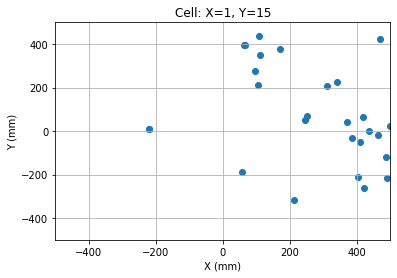

In [28]:
#Plot the cell with the maximum number of particles
cx = Particles.loc[(Particles["nShow"]==Max_ShowId) & (Particles["nClst"]==Max_ClustId ),'Det_Xc'].iloc[0]
cy = Particles.loc[(Particles["nShow"]==Max_ShowId) & (Particles["nClst"]==Max_ClustId ),'Det_Yc'].iloc[0]
Mx = Particles.loc[(Particles["nShow"]==Max_ShowId) & (Particles["nClst"]==Max_ClustId ),'dX_mm']
My = Particles.loc[(Particles["nShow"]==Max_ShowId) & (Particles["nClst"]==Max_ClustId ),'dY_mm']
plt.scatter(Mx,My)
plt.title('Cell: X=%i, Y=%i'%(cx,cy))
plt.xlabel('dX/mm')
plt.ylabel('dY/mm')
#Cell for detector of 1 m^2 
plt.axis([-500,500,-500,500])
#Cell for detector of 0.30 x 0.30 m^2
#plt.axis([-150,150,-150,150])
plt.grid(True)

In [29]:
Particles.head() # jag

,PId,nShow,nClst,Mass,X,Y,T,Px,Py,Pz,P,Ene,Theta,Phi,R,Det_Xc,Det_Yc,dX_mm,dY_mm
0,1,1,1,0.0,202.8570,-52.80860,70347.8,-0.014051,0.000221,0.052103,0.053965,0.053965,15.0941,179.100,209.618011,202.5,-52.5,357.0,-308.60
1,1,1,2,0.0,43.9967,-18.30410,70512.6,-0.182562,0.015446,0.487750,0.521025,0.521025,20.5877,175.164,47.652384,43.5,-18.5,496.7,195.90
2,1,1,3,0.0,26.9723,-5.68421,70534.3,-0.126190,0.013492,0.323988,0.347957,0.347957,21.3907,173.897,27.564746,26.5,-5.5,472.3,-184.21
3,1,1,4,0.0,33.2305,3.98663,70528.2,-0.020200,0.002715,0.052752,0.056553,0.056553,21.1248,172.344,33.468782,33.5,3.5,-269.5,486.63
4,1,1,5,0.0,79.4011,13.43910,70477.4,-0.018291,0.003078,0.052332,0.055522,0.055522,19.5160,170.449,80.530392,79.5,13.5,-98.9,-60.90


def find_Distribution(Particles, Electron_Code, Ene, 6, intervals_array):
    # Ejemplo: Energia de los electrones
    # n. bins: 6, 8... 10
    # intervals: [0, 0.1, 0.2, 0.4, 0.8, 1.5],.... GeV
    
    # output
    # [12435, 8313, 4300, 1600, 216, 35]

def find_Distribution(Clusters, Electrones, NPart, 6, intervals_array):
    # Ejemplo: Multiplicidad de los Clusters de 
    
    # n. bins: 6, 8... 10
    # intervals: [0, 0.1, 0.2, 0.4, 0.8, 1.5],.... GeV
    
    # output
    # [12435, 8313, 4300, 1600, 216, 35]

def find_Distribution(DF, Seleccion en el df, Variable, NIntervals, intervals_array):
    